In [1]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pydot==1.3.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import errno
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\User\Desktop\Data\train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\User\Desktop\Data\train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5069 files belonging to 3 classes.
Using 4056 files for training.
Found 5069 files belonging to 3 classes.
Using 1013 files for validation.


In [4]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
class_names = train_ds.class_names
print(class_names)

['COVID19', 'NORMAL', 'PNEUMONIA']


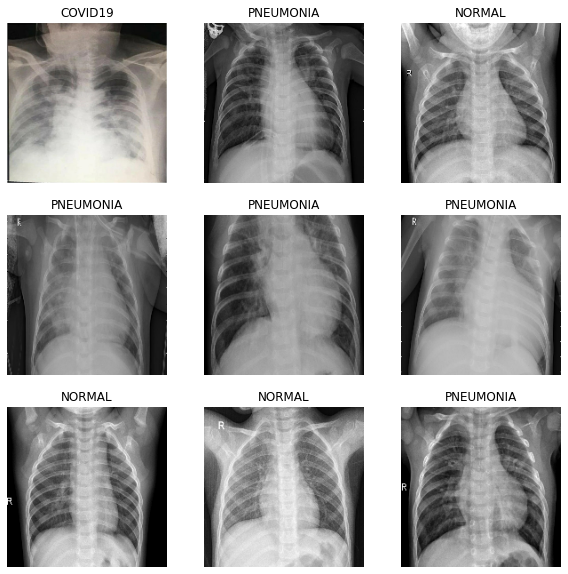

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [7]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomZoom(0.10)
    ]
)
    

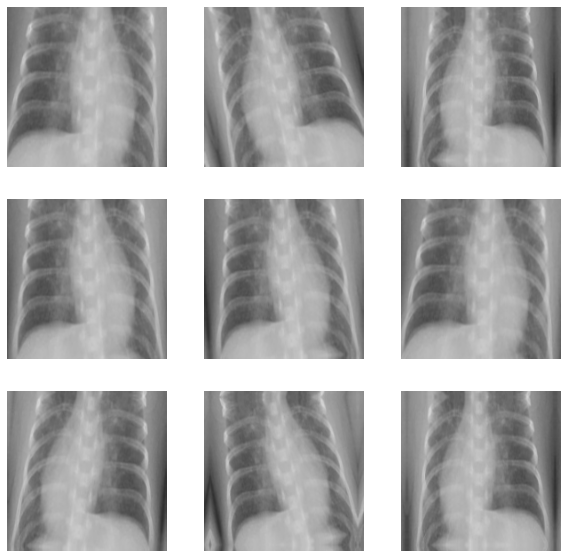

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [10]:
keras.backend.clear_session()

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 5, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 5, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 5, padding="same")(x)
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.SeparableConv2D(724, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [11]:
 model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 32)        2432      
                                                                 
 activation (Activation)     (None, 90, 90, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                             

In [10]:
def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.008)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [11]:
    epochs = 100

    model.compile(optimizer= keras.optimizers.Adam(),
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ["accuracy"])

    history = model.fit(
        train_ds, epochs = epochs, 
        callbacks = [lr_callback],
        validation_data = val_ds)

Epoch 1/100
127/127 [==============================] - 63s 482ms/step - loss: 0.8961 - accuracy: 0.6610 - val_loss: 0.8160 - val_accuracy: 0.6782 - lr: 0.0010
Epoch 2/100
127/127 [==============================] - 61s 474ms/step - loss: 0.6923 - accuracy: 0.7108 - val_loss: 0.4555 - val_accuracy: 0.8263 - lr: 0.0010
Epoch 3/100
127/127 [==============================] - 61s 477ms/step - loss: 0.4495 - accuracy: 0.8326 - val_loss: 0.3344 - val_accuracy: 0.9003 - lr: 0.0010
Epoch 4/100
127/127 [==============================] - 63s 494ms/step - loss: 0.3392 - accuracy: 0.8812 - val_loss: 0.2296 - val_accuracy: 0.9269 - lr: 0.0010
Epoch 5/100
127/127 [==============================] - 64s 496ms/step - loss: 0.2841 - accuracy: 0.9046 - val_loss: 0.1837 - val_accuracy: 0.9408 - lr: 0.0010
Epoch 6/100
127/127 [==============================] - 65s 509ms/step - loss: 0.2449 - accuracy: 0.9098 - val_loss: 0.1684 - val_accuracy: 0.9427 - lr: 0.0010
Epoch 7/100
127/127 [=========================

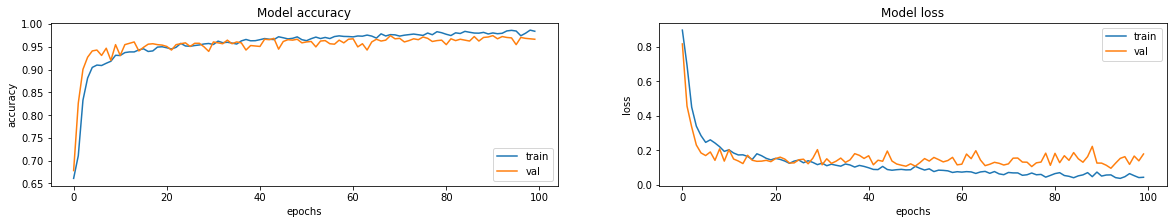

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [14]:
image_path = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[0].png"
image_path2 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[1].png"
image_path3 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[2].png"
image_path4 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[3].png"
image_path5 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[4].png"
image_path6 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[5].png"
image_path7 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[6].png"
image_path8 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[7].png"
image_path9 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[8].png"
image_path10 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[9].png"
image_path11 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[10].png"
image_path12 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[11].png"
image_path13 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[12].png"
image_path14 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[13].png"
image_path15 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[14].png"
image_path16 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[15].png"
image_path17 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[16].png"
image_path18 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[17].png"
image_path19 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[18].png"
image_path20 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[19].png"
merged_path = [image_path,image_path2,image_path3,image_path4,image_path5,image_path6,image_path7,image_path8,image_path9,image_path10, 
               image_path11, image_path12, image_path13,image_path14,image_path15, image_path16,image_path17, image_path18,image_path19,
               image_path20]

for img_path in merged_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 52.02 percent confidence.
This image most likely belongs to COVID19 with a 57.60 percent confidence.
This image most likely belongs to COVID19 with a 57.60 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 55.25 percent confidence.
This image most likely belongs to COVID19 with a 54.94 percent confidence.
This image most likely be

In [15]:
image_path21 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[20].png"
image_path22 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[21].png"
image_path23 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[22].png"
image_path24 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[23].png"
image_path25 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[24].png"
image_path26 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[25].png"
image_path27 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[26].png"
image_path28 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[27].png"
image_path29 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[28].png"
image_path30 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[29].png"
image_path31 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[30].png"
image_path32 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[31].png"
image_path33 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[32].png"
image_path34 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[33].png"
image_path35 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[34].png"
image_path36 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[35].png"
image_path37 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[36].png"
image_path38 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[37].png"
image_path39 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[38].png"
image_path40 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[39].png"
merged_path = [image_path21,image_path22,image_path23,image_path24,image_path25,image_path26,image_path27,image_path28,image_path29,image_path30, 
               image_path31, image_path32, image_path33,image_path34,image_path35, image_path36,image_path37, image_path38,image_path39,
               image_path40]

for img_path in merged_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs to NORMAL with a 55.07 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.57 percent confidence.
This image most likely belongs to NORMAL with a 44.96 percent confidence.
This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs to NORMAL with a 56.37 percent confidence.
This image most likely belongs to NORMAL with a 57.56 percent confidence.
This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 46.93 percent confidence.
This image most likely belongs to NORMAL with a 57.14 percent confidence.
This image most likely belongs to NORMAL with a 57.60 percent confidence.
This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs t

In [16]:
image_path41 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[40].png"
image_path42 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[41].png"
image_path43 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[42].png"
image_path44 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[43].png"
image_path45 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[44].png"
image_path46 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[45].png"
image_path47 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[46].png"
image_path48 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[47].png"
image_path49 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[48].png"
image_path50 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[49].png"
image_path51 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[50].png"
image_path52 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[51].png"
image_path53 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[52].png"
image_path54 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[53].png"
image_path55 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[54].png"
image_path56 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[55].png"
image_path57 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[56].png"
image_path58 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[57].png"
image_path59 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[58].png"
image_path60 = r"C:\Users\User\Desktop\Test Data set\Filter\xtest[59].png"
merged_path = [image_path41,image_path42,image_path43,image_path44,image_path45,image_path46,image_path47,image_path48,image_path49,image_path50, 
               image_path51, image_path52, image_path53,image_path54,image_path55, image_path56,image_path57, image_path58,image_path59,
               image_path60]

for img_path in merged_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.

In [17]:
Non1 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (1).jpg"
Non2 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (2).jpg"
Non3 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (3).jpg"
Non4 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (4).jpg"
Non5 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (5).jpg"
Non6 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (6).jpg"
Non7 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (7).jpg"
Non8 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (8).jpg"
Non9 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (9).jpg"
Non10 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (10).jpg"
Non11 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (11).jpg"
Non12 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (12).jpg"
Non13 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (13).jpg"
Non14 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (14).jpg"
Non15 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (15).jpg"
Non16 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (16).jpg"
Non17 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (17).jpg"
Non18 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (18).jpg"
Non19 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (19).jpg"
Non20 = r"C:\Users\User\Desktop\Test Data set\Non fil\zCOVID19 (20).jpg"
merged_path = [Non1,Non2,Non3,Non4,Non5,Non6,Non7,Non8,Non9,Non10, 
              Non11, Non12, Non13,Non14,Non15, Non16,Non17,Non18,Non19,
               Non20]

for Non in merged_path:
    img = keras.preprocessing.image.load_img(
        Non, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to COVID19 with a 57.27 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.25 percent confidence.
This image most likely belongs to COVID19 with a 57.59 percent confidence.
This image most likely belongs to COVID19 with a 57.59 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely be

In [34]:
Non21 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (1).jpg"
Non22 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (2).jpg"
Non23 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (3).jpg"
Non24 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (4).jpg"
Non25 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (5).jpg"
Non26 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (6).jpg"
Non27 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (7).jpg"
Non28 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (8).jpg"
Non29 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (9).jpg"
Non30 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (10).jpg"
Non31 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (11).jpg"
Non32 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (12).jpg"
Non33 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (13).jpg"
Non34 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (14).jpg"
Non35 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (15).jpg"
Non36 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (16).jpg"
Non37 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (17).jpg"
Non38 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (18).jpg"
Non39 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (19).jpg"
Non40 = r"C:\Users\User\Desktop\Test Data set\Non filter\zNORMAL (20).jpg"
merged_path = [Non21,Non22,Non23,Non24,Non25,Non26,Non27,Non28,Non29,Non30, 
              Non31, Non32, Non33,Non34,Non35, Non36,Non37,Non38,Non39,
               Non40]

for Non in merged_path:
    img = keras.preprocessing.image.load_img(
        Non, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs to NORMAL with a 57.58 percent confidence.
This image most likely belongs to PNEUMONIA with a 56.06 percent confidence.
This image most likely belongs to NORMAL with a 55.56 percent confidence.
This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs to NORMAL with a 57.57 percent confidence.
This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs to NORMAL with a 57.58 percent confidence.
This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs to N

In [19]:
Non41 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (1).jpg"
Non42 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (2).jpg"
Non43 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (3).jpg"
Non44 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (4).jpg"
Non45 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (5).jpg"
Non46 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (6).jpg"
Non47 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (7).jpg"
Non48 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (8).jpg"
Non49 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (9).jpg"
Non50 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (10).jpg"
Non51 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (11).jpg"
Non52 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (12).jpg"
Non53 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (13).jpg"
Non54 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (14).jpg"
Non55 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (15).jpg"
Non56 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (16).jpg"
Non57 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (17).jpg"
Non58 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (18).jpg"
Non59 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (19).jpg"
Non60 = r"C:\Users\User\Desktop\Test Data set\Non fil\zPNEUMONIA (20).jpg"
merged_path = [Non41,Non42,Non43,Non44,Non45,Non46,Non47,Non48,Non49,Non50, 
              Non51, Non52, Non53,Non54,Non55, Non56,Non57,Non58,Non59,
               Non60]

for Non in merged_path:
    img = keras.preprocessing.image.load_img(
        Non, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.28 percent confidence.
This image most likely belongs to PNEUMONIA with a 55.01 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.59 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.40 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.

In [20]:
Noi1 = r"C:\Users\User\Desktop\noise\cov[1].jpg"
Noi2 = r"C:\Users\User\Desktop\noise\cov[2].jpg"
Noi3 = r"C:\Users\User\Desktop\noise\cov[3].jpg"
Noi4 = r"C:\Users\User\Desktop\noise\cov[4].jpg"
Noi5 = r"C:\Users\User\Desktop\noise\cov[5].jpg"
Noi6 = r"C:\Users\User\Desktop\noise\cov[6].jpg"
Noi7 = r"C:\Users\User\Desktop\noise\cov[7].jpg"
Noi8 = r"C:\Users\User\Desktop\noise\cov[8].jpg"
Noi9 = r"C:\Users\User\Desktop\noise\cov[9].jpg"
Noi10 = r"C:\Users\User\Desktop\noise\cov[10].jpg"
Noi11 = r"C:\Users\User\Desktop\noise\cov[11].jpg"
Noi12 = r"C:\Users\User\Desktop\noise\cov[12].jpg"
Noi13 = r"C:\Users\User\Desktop\noise\cov[13].jpg"
Noi14 = r"C:\Users\User\Desktop\noise\cov[14].jpg"
Noi15 = r"C:\Users\User\Desktop\noise\cov[15].jpg"
Noi16 = r"C:\Users\User\Desktop\noise\cov[16].jpg"
Noi17 = r"C:\Users\User\Desktop\noise\cov[17].jpg"
Noi18 = r"C:\Users\User\Desktop\noise\cov[18].jpg"
Noi19 = r"C:\Users\User\Desktop\noise\cov[19].jpg"
Noi20 = r"C:\Users\User\Desktop\noise\cov[20].jpg"
merged_path = [Noi1,Noi2,Noi3,Noi4,Noi5,Noi6,Noi7,Noi8,Noi9,Noi10, 
              Noi11, Noi12, Noi13,Noi14,Noi15, Noi16,Noi17,Noi18,Noi19,
               Noi20]

for Non in merged_path:
    img = keras.preprocessing.image.load_img(
        Non, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to COVID19 with a 57.58 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 50.74 percent confidence.
This image most likely belongs to COVID19 with a 57.59 percent confidence.
This image most likely belongs to COVID19 with a 57.35 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely belongs to COVID19 with a 57.61 percent confidence.
This image most likely be

In [21]:
Noi21 = r"C:\Users\User\Desktop\noise\Pneu[1].jpg"
Noi22 = r"C:\Users\User\Desktop\noise\Pneu[2].jpg"
Noi23 = r"C:\Users\User\Desktop\noise\Pneu[3].jpg"
Noi24 = r"C:\Users\User\Desktop\noise\Pneu[4].jpg"
Noi25 = r"C:\Users\User\Desktop\noise\Pneu[5].jpg"
Noi26 = r"C:\Users\User\Desktop\noise\Pneu[6].jpg"
Noi27 = r"C:\Users\User\Desktop\noise\Pneu[7].jpg"
Noi28 = r"C:\Users\User\Desktop\noise\Pneu[8].jpg"
Noi29 = r"C:\Users\User\Desktop\noise\Pneu[9].jpg"
Noi30 = r"C:\Users\User\Desktop\noise\Pneu[10].jpg"
Noi31 = r"C:\Users\User\Desktop\noise\Pneu[11].jpg"
Noi32 = r"C:\Users\User\Desktop\noise\Pneu[12].jpg"
Noi33 = r"C:\Users\User\Desktop\noise\Pneu[13].jpg"
Noi34 = r"C:\Users\User\Desktop\noise\Pneu[14].jpg"
Noi35 = r"C:\Users\User\Desktop\noise\Pneu[15].jpg"
Noi36 = r"C:\Users\User\Desktop\noise\Pneu[16].jpg"
Noi37 = r"C:\Users\User\Desktop\noise\Pneu[17].jpg"
Noi38 = r"C:\Users\User\Desktop\noise\Pneu[18].jpg"
Noi39 = r"C:\Users\User\Desktop\noise\Pneu[19].jpg"
Noi40 = r"C:\Users\User\Desktop\noise\Pneu[20].jpg"
merged_path = [Noi21,Noi22,Noi23,Noi24,Noi25,Noi26,Noi27,Noi28,Noi29,Noi30, 
              Noi31, Noi32, Noi33,Noi34,Noi35, Noi36,Noi37,Noi38,Noi39,
               Noi40]

for Non in merged_path:
    img = keras.preprocessing.image.load_img(
        Non, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.39 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.

In [22]:
Noi41 = r"C:\Users\User\Desktop\noise\Norm[1].jpg"
Noi42 = r"C:\Users\User\Desktop\noise\Norm[2].jpg"
Noi43 = r"C:\Users\User\Desktop\noise\Norm[3].jpg"
Noi44 = r"C:\Users\User\Desktop\noise\Norm[4].jpg"
Noi45 = r"C:\Users\User\Desktop\noise\Norm[5].jpg"
Noi46 = r"C:\Users\User\Desktop\noise\Norm[6].jpg"
Noi47 = r"C:\Users\User\Desktop\noise\Norm[7].jpg"
Noi48 = r"C:\Users\User\Desktop\noise\Norm[8].jpg"
Noi49 = r"C:\Users\User\Desktop\noise\Norm[9].jpg"
Noi50 = r"C:\Users\User\Desktop\noise\Norm[10].jpg"
Noi51 = r"C:\Users\User\Desktop\noise\Norm[11].jpg"
Noi52 = r"C:\Users\User\Desktop\noise\Norm[12].jpg"
Noi53 = r"C:\Users\User\Desktop\noise\Norm[13].jpg"
Noi54 = r"C:\Users\User\Desktop\noise\Norm[14].jpg"
Noi55 = r"C:\Users\User\Desktop\noise\Norm[15].jpg"
Noi56 = r"C:\Users\User\Desktop\noise\Norm[16].jpg"
Noi57 = r"C:\Users\User\Desktop\noise\Norm[17].jpg"
Noi58 = r"C:\Users\User\Desktop\noise\Norm[18].jpg"
Noi59 = r"C:\Users\User\Desktop\noise\Norm[19].jpg"
Noi60 = r"C:\Users\User\Desktop\noise\Norm[20].jpg"
merged_path = [Noi41,Noi42,Noi43,Noi44,Noi45,Noi46,Noi47,Noi48,Noi49,Noi50, 
              Noi51, Noi52, Noi53,Noi54,Noi55, Noi56,Noi57,Noi58,Noi59,
               Noi60]

for Non in merged_path:
    img = keras.preprocessing.image.load_img(
        Non, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to NORMAL with a 57.57 percent confidence.
This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.61 percent confidence.
This image most likely belongs to PNEUMONIA with a 57.54 percent confidence.
This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs to NORMAL with a 57.55 percent confidence.
This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely belongs to NORMAL with a 57.60 percent confidence.
This image most likely belongs to NORMAL with a 53.07 percent confidence.
This image most likely belongs to PNEUMONIA with a 40.10 percent confidence.
This image most likely belongs to PNEUMONIA with a 50.79 percent confidence.
This image most likely belongs to NORMAL with a 57.61 percent confidence.
This image most likely 

In [23]:
pip install --upgrade pandoc


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 117.8/117.8 KB 2.3 MB/s eta 0:00:00
  Created wheel for pandoc: filename=pandoc-2.2-py3-none-any.whl size=29561 sha256=59cd88c72d09456ea7b3452856346964d849bfe111bef0c56ffb707ce556262e
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\2d\da\b1\54ff0401ef9b07b60c7fc9cffe616f243cf27dc3d04bd5d5ef
Successfully built pandoc


In [1]:
pip install nbconvert

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install pyppeteer

     ---------------------------------------- 83.4/83.4 KB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 98.6/98.6 KB 5.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


SyntaxError: invalid syntax (Temp/ipykernel_1208/3209447917.py, line 1)